## Objective

We pick parts of points as training set, doing diffusion maps and k-means to get the training label.
<br>We want to use neural network to build up a classifier to solve the classification of picture.

## framework

In [1]:
using MAT , PyPlot , LinearAlgebra , Random , StatsBase , Clustering , Images , Statistics , Arpack

## convert image to matrix

In [2]:
function get_Z(img)
    width , length = size(img) ;
    n = width*length ;
    # ColorNorm = zeros(n) ;
    # PixelNorm  = zeros(n) ;
    
    Z = zeros(n , 5) ;
    t = 1 ;
    for ii = 1 : width
        for jj = 1 : length
            # RGB
            Z[t,1] = img[ii,jj].r  ;
            Z[t,2] = img[ii,jj].g ;
            Z[t,3] = img[ii,jj].b ;
            
            # xy
            Z[t,4] = ii ;
            Z[t,5] = jj ;
            
            # ColorNorm[t] = Z[t,1]^2 + Z[t,2]^2 + Z[t,3]^2 ;
            # PixelNorm[t]  = Z[t,4]^2 + Z[t,5]^2 ;
            t += 1 ;
        end
    end
    
    # normalize the range of 5 dimension to [0 , 1]
    #for ii = 1 : 5
    #    min  = minimum(Z[: , ii]) ;
    #    max = maximum(Z[: , ii]) ;
    #    
    #    Z[: , ii] = (Z[: , ii] .- min) ./ (max - min) ;
    #end
    
    #Z[: , 1:3] .*= sqrt(median(PixelNorm) / median(ColorNorm)) ;
    
    Z[: , 4:5] ./= (width + length)/2 ;
    
    return Z ;
    
end

get_Z (generic function with 1 method)

## pick random points

In [3]:
function partition(Z , L)
    # Randomly pick L points from Z
    idx = sort(sample(1:size(Z , 1) , L , replace = false)) ;
    
    X = Z[idx , :] ;
    
    return X , idx ;
end

partition (generic function with 1 method)

## Diffusion maps

In [4]:
function DiffMap(X , c = 3 , sigma = 7)
    # get_K
    n = size(X,1) ;
    K = zeros(n,n) ;
    for ii = 1 : n
        for jj = ii+1 : n
            K[ii,jj] = sum((X[ii,:] - X[jj,:]).^2) ;
            K[jj,ii] = K[ii,jj] ;
        end
    end
    
    # local scaling
    # sigma : choose the 7th nearest point as scale for each points
    #temp = sort(K , dims = 2 , alg = QuickSort) ;
    #temp = temp[: , sigma] ;
    #K = exp.(-K ./(sqrt.(temp*transpose(temp)))) ;
    
    # single scaling
    m = Int(round(0.1 * n)) ;
    temp = sort(K , dims = 2 , alg = QuickSort) ;
    temp = mean(temp[: , 1:m] , dims = 2) ;
    sigma = median(temp) ;
    K = exp.(-K ./ sigma) ;
    
    # get_Ppron
    Dsqinv = 1 ./ sqrt.(sum(K , dims = 2)) ;
    P_pron = K .* Dsqinv .* transpose(Dsqinv) ;
    
    K = 0 ; # release K
    
    # get_eig
    S , U = eigen(P_pron) ; # S is eigenvalue and U is eigenvector
    print("the imag of eigenvalue : " , maximum(abs.(imag(S)))) ;
    S = real(S) ;
    idx = partialsortperm(S , 2 : c+1 , rev = true) ;
    S = S[idx] ;
    U = U[: , idx] ;
    print(" ,the imag of eigenvector : " , maximum(abs.(imag(K))) , "\n") ;
    U = real(U) ;
    
    return U .* Dsqinv .* transpose(S) ;
end

DiffMap (generic function with 3 methods)

In [5]:
function Color1(group)
    dict = Dict(1 => "red" , 2 => "green" , 3 => "blue" , 4 => "black" , 5 => "brown" , 6 => "cyan" , 7 => "orange") ;
    
    cc = Array{String}(undef, size(group , 1)) ;
    for ii = 1 : size(group , 1)
        cc[ii] = dict[group[ii]] ;
    end
    
    return cc ;
end

Color1 (generic function with 1 method)

## Neural network model

In [ ]:
# model
load("model256.png") 

**optimizer:** Stochastic Gradient Descent(sgd)  
**loss function:** Mean squared error  
**activate function:** sigmoid  

In [ ]:
function sigmoid(x , W , b)

    return 1 ./ (1 .+ exp.(-(W * x .+ b))) ;
end

In [ ]:
function Stochastic_Gradient_Descent(x , y ; batch_size = 10 , epoch = 2000 , eta = 0.1)
    
    # Initialize weights and biases 
    s = 256 ; rng = MersenneTwister(1234) ;
    
    W2 = 0.5*randn(rng , s , size(x , 2))  ;
    W3 = 0.5*randn(rng , size(y , 2) , s) ;
    b2  = 0.5*randn(rng , s ) ;
    b3  = 0.5*randn(rng , size(y , 2) ) ;
    
    # cost function
    function cost(W2 , W3 , b2 , b3)
        
        train_loss = 0 ;
        for i = 1 : N
            a2 = sigmoid(x[i , :] , W2 , b2) ;
            a3 = sigmoid(a2 , W3 , b3) ;
            train_loss = train_loss + sum((y[i , :] .- a3) .^ 2) ;
        end
        
        return train_loss / N ;
    end
    
    # Forward and Back propagate 
    N = size(x , 1) ;
    K = N / batch_size ;
    train_cost = zeros(epoch , 1) ;
    
    for s = 1 : epoch
        idx = randperm(N) ;
        t = 1 ;
        for ii = 1 : K
            temp1 = 0 ; temp2 = 0 ; temp3 = 0 ; temp4 = 0 ;
            for jj = 1 : batch_size
                # Forward pass
                a2 = sigmoid(x[idx[t] , :] , W2 , b2) ;
                a3 = sigmoid(a2 , W3 , b3) ;
                # Backward pass
                delta3 = a3 .* (1 .- a3) .* (a3 - y[idx[t] , :]) ;
                delta2 = a2 .* (1 .- a2) .* (transpose(W3) * delta3) ;
                # Summation
                temp1 = temp1 .+ delta2 * transpose(x[idx[t] , :]) ;
                temp2 = temp2 .+ delta3 * transpose(a2) ;
                temp3 = temp3 .+ delta2 ;
                temp4 = temp4 .+ delta3 ;
                t = t+1 ;
            end
            # Gradient step
            W2 = W2 .- eta * temp1 / batch_size ;
            W3 = W3 .- eta * temp2 / batch_size ;
            b2  = b2 .- eta * temp3 / batch_size ;
            b3  = b3 .- eta * temp4 / batch_size ;
    
        end
        # Monitor progress
        train_cost[s] = cost(W2 , W3 , b2 , b3) ;
    end
    
    return W2 , W3 , b2 , b3 , train_cost ;
    
end

## Implementation

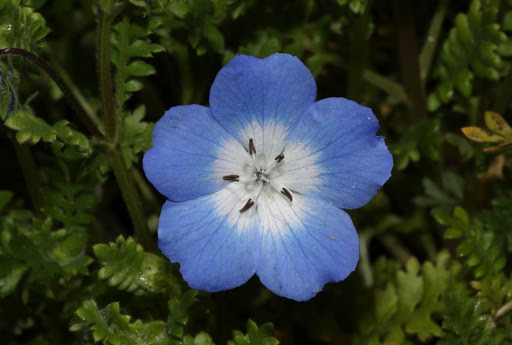

In [9]:
img = load("test1.jpg")

In [26]:
L = 500 ;
cluster = 2 ;
# diffusion map
test_x = get_Z(img) ;
train_x , idx = partition(test_x , L) ;
Y = DiffMap(train_x , 3) ;

the imag of eigenvalue : 0.0 ,the imag of eigenvector : 0


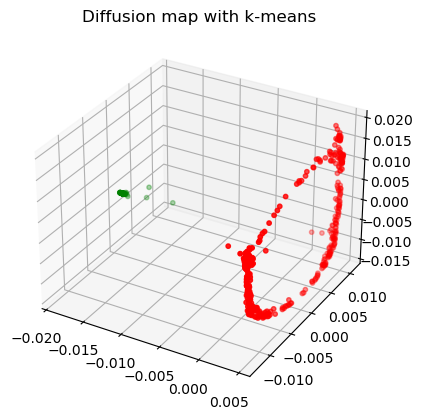

PyObject Text(0.5, 1.0, 'Diffusion map with k-means')

In [28]:
# k-means
Rdata = kmeans(transpose(Y), cluster) ;
train_label = Rdata.assignments ;
# plot trainnig set
scatter3D(Y[:,1] , Y[:,2] , Y[:,3] , c = Color1(train_label) , s = 10)
title("Diffusion map with k-means")

In [13]:
# one-hot encoding
# 1 => [1,0]
# 2 => [0,1]
train_label_onehot = zeros(size(train_label,1) , cluster) ;
for ii = 1 : size(train_label , 1)
    train_label_onehot[ii,train_label[ii]] = 1 ;
end

## training

In [14]:
@time W2 , W3 , b2 , b3 , train_cost = Stochastic_Gradient_Descent(train_x , train_label_onehot , batch_size = 10 , epoch = 2000 , eta = 0.1) ;

 26.514019 seconds (68.13 M allocations: 56.639 GiB, 17.92% gc time)


## loss process

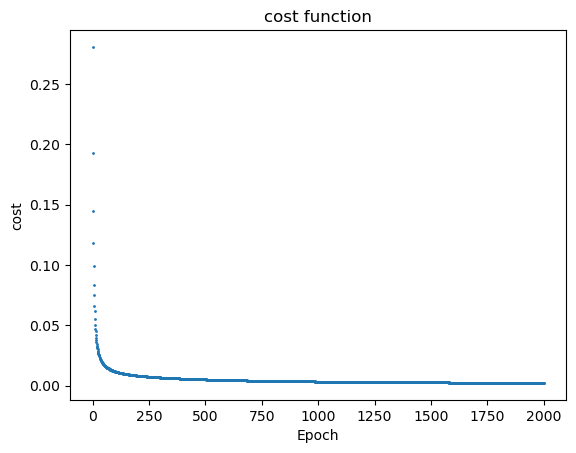

In [15]:
scatter(1 : size(train_cost,1) , train_cost , s = 1 )
title("cost function") ; xlabel("Epoch") ; ylabel("cost") ;

## predict

In [16]:
# use original data
test_label = Array{Int64,1}(undef,size(test_x,1)) ;
for ii = 1 : size(test_x,1)
    a2 = sigmoid(test_x[ii,:] , W2 , b2) ;
    ~ , test_label[ii] = findmax(sigmoid(a2 , W3 , b3)) ;
end

## show picture

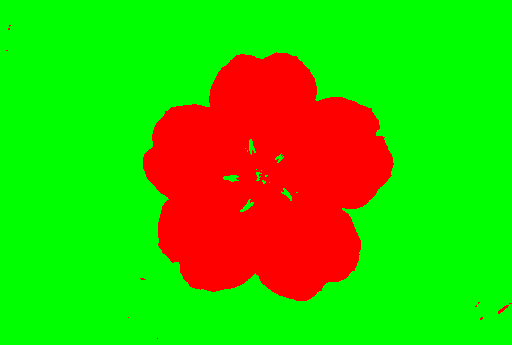

In [17]:
dict = Dict(1 => RGB(1,0,0) , 2 => RGB(0,1,0) , 3 => RGB(0,0,1) , 4 => RGB(0,0,0) , 5 => RGB(0.5,0.16,0.16) , 6 => RGB(0,1,1) , 7 => RGB(1,0.38,0)) ;

img_label = Array{RGB{Float64} , 2}(undef,345,512) ;
t = 1 ;
for ii = 1 : 345
    for jj = 1:512
        img_label[ii,jj] = dict[test_label[t]] ;
        t += 1 ;
    end
end
img_label

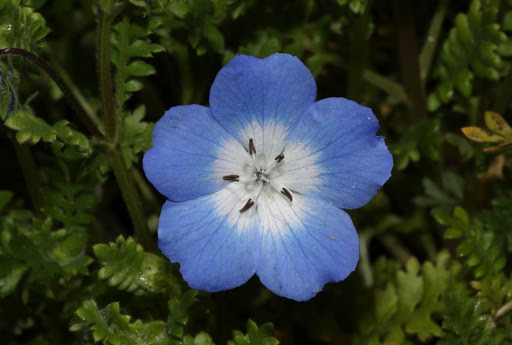

In [46]:
img

## Reference

1. [Deep Learning: An Introduction for Applied Mathematicians. Catherine F. Higham, Desmond J. Higham](https://arxiv.org/pdf/1801.05894.pdf)
2. An Introduction to Diffusion Maps. J. de la Porte, B. M. Herbst, W. Hereman, S. J. van der Walt